In [1]:
import autograd.numpy as np
from autograd import grad, hessian
import colorsys
import json
import matplotlib.pyplot as plt
import numpy as np2
from numpy.random import multivariate_normal as mvn
import pandas as pd
import random as ran
import ternary
from scipy.optimize import minimize
import seaborn as sns
from scipy.stats import norm
import scipy
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import mpltern

In [2]:
class tagClass:
    """Class to store each tag coordinate data."""
    def __init__(self, data: dict, tClass):
        self.x = data.get("x")
        self.y = data.get("y")
        self.fn = data.get("fn").removeprefix("40data/")
        self.label = data.get("label")
        self.tagX, self.tagX2, self.tagY, self.tagY2 = self.getSnip()
        self.tagClass = tClass
    
    # Get functions
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    def getFn(self):
        return self.fn
    def getLabel(self):
        return self.label
    def getFileClass(self):
        return tagClass
    
    # Returns coordinates for 16 x 16 crop around tag centre
    def getSnip(self):
        s = 16
        newX = self.x-(s/2)
        if newX%2 != 0:
            newX -= 1
        newY = self.y-(s/2)
        if newY%2 != 0:
            newY -= 1
        return int(newX), int(newX+s), int(newY), int(newY+s)
    
    def getSnipCoords(self):
        return self.tagX, self.tagX2, self.tagY, self.tagY2

In [3]:
def getTags(rawData, nType):
    """Process raw data into objects of Tag class."""
    listData = []
    for n in nType:
        for i in rawData[n]:
            i = dict(i)
            d = tagClass(i, n)
            listData.append(d)
    return listData

def getPhoto(tag: tagClass):
    """Returns the image this tag is from."""
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo

def getSnipPlot(tag):
    """Return a 16 x 16 pixel crop in the image for this tag."""
    tagX, tagX2, tagY, tagY2 = tag.getSnipCoords()
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo[tagY:tagY2,tagX:tagX2].astype(np.float32)

def getBayer(x, y):
    """Find Bayer filter pixel colour for given coordinate."""
    if x%2 == 0:
        if y%2 == 0:
            return "R" #RGGB
        else:
            return "G" #GBRG
    else:
        if y%2 == 0:
            return "G" #GRBG
        else:
            return "B" #BGGR
        
def getPixels(t: tuple, photo):
    """Returns RGB values for this tag as ratio."""
    tagX, tagX2, tagY, tagY2 = t
    red = 0
    green = 0
    blue = 0
    for px in range(tagX, tagX2):
        for py in range(tagY, tagY2):
            col = getBayer(py, px)
            if col == 'R':
                red += int(photo[py, px])
            elif col == 'G':
                green += int(photo[py, px])
            else:
                blue += int(photo[py, px])
    totalSum = red + (0.5*green) + blue
    return red/totalSum, (0.5*green)/totalSum, blue/totalSum


In [4]:
def simulate_pixel(pixelCoord, tagCoord, tagBrightness, bgBrightness, psfWidth):
    """Simulate pixel value given its distance from the tag centre."""
    dist = np.sqrt(np.sum((tagCoord - pixelCoord)**2))
    # If outside tag width:
    if dist>psfWidth+0.5:
           return bgBrightness
    
    # If inside tag width:
    elif dist<psfWidth-0.5:
        return tagBrightness
    
    # If on the edge of the tag:
    else:
       return (bgBrightness*(0.5 + dist - psfWidth)-tagBrightness*(dist - psfWidth - 0.5))

def simulate_image(tagCoord, t, b, psfWidth, imgShape):
    """Call simulate for each pixel in given image."""
    pixel_value_guesses = []

    # Loop over pixel coords for each colour...
    for pixX in range(imgShape[0]):
        for pixY in range(imgShape[1]):
            # Get colour based on bayer
            colour = pixX % 2 + pixY % 2
            # Call simulate_pixel with the coords of the pixel
            # and the appropriate element from the rgb vectors...etc
            pixel_value_guesses.append(simulate_pixel([pixX, pixY], tagCoord,
                                                      t[colour], b[colour], psfWidth))
    return np.array(pixel_value_guesses).astype(np.float32)

def cost_function(params, psfWidth, trueImg):
    """Returns the sum squared error of predicted pixel values compared
    to the true image."""
    tagCoord = params[:2]
    tagBright = params[2:5]
    bgBright = params[5:]
    pixel_value_guesses = simulate_image(tagCoord, tagBright, bgBright,
                                         psfWidth, trueImg.shape)
    # Sum square error over all the pxiels between the true image
    # and the simulated image
    square_error = 0.01*np.sum([(s - a)**2 for (s, a) in zip(pixel_value_guesses,
                                                             trueImg.flatten())])
    return square_error

In [5]:
import pickle
dbfile=open('mean_full_tags', 'rb')
tagsX = pickle.load(dbfile)

dbfile2=open('hess_full_tags', 'rb')
tagsHessInv = pickle.load(dbfile2)

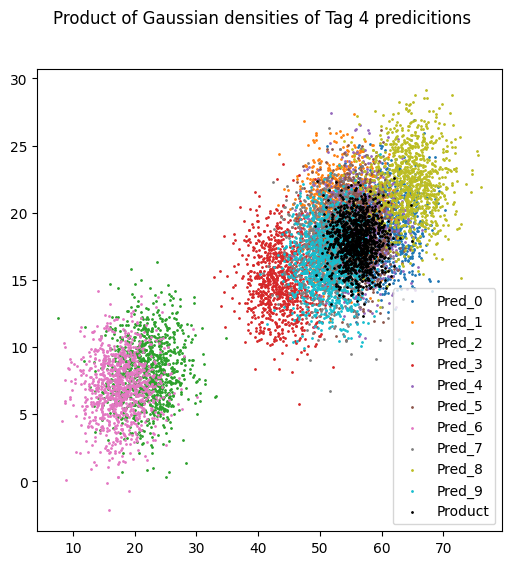

In [23]:
covs = []
means = []

image=5

plt.figure(figsize=(6,6))
plt.suptitle("Product of Gaussian densities of Tag 4 predicitions")


partition = [1,10,20,30,40]

count=0

        
 
# Inverse Hessian can be used as covariance of the Gaussian
covA = np.linalg.inv(tagsHessInv[image][0][2:5,2:5])
# Maximum-likelihood estimation gives the mean of the Gaussian
meanA = tagsX[image][0][2:5]


for i in range(0,10):
    covB = np.linalg.inv(tagsHessInv[image][i][2:5,2:5])
    meanB = tagsX[image][i][2:5]


    z = mvn(meanB, covB, 1000)
    plt.scatter(z[:,0], z[:,1], 1, label="Pred_"+str(i))

    covC = np.linalg.inv(np.linalg.inv(covA) + np.linalg.inv(covB))
    meanC = covC @ ((np.linalg.inv(covA) @ meanA + np.linalg.inv(covB) @ meanB))

covs.append(covC)
means.append(meanC)
count+=1
z = mvn(meanC, covC, 1000)

plt.scatter(z[:,0], z[:,1], 1, color='black', label="Product")
plt.legend()


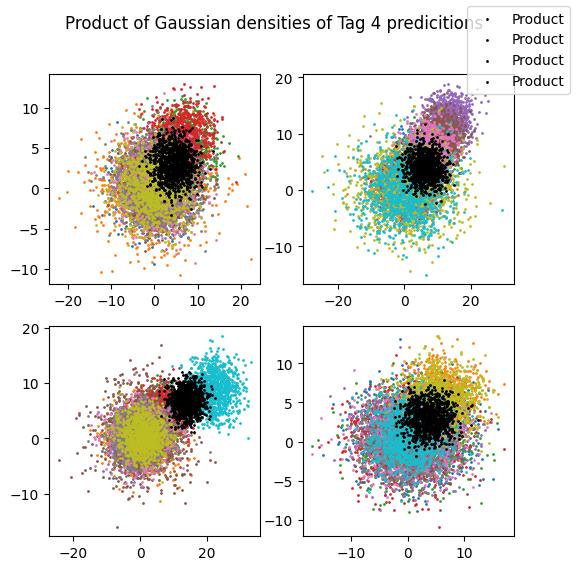

In [27]:
covs = []
means = []

img_num=[4]

fig, axes = plt.subplots(2,2, figsize=(6, 6))
fig.suptitle("Product of Gaussian densities of Tag 4 predicitions")

partition = [1,10,20,30,40]

count=0
for x in range(2):
    for y in range(2):
        
        for image in img_num: 
            # Inverse Hessian can be used as covariance of the Gaussian
            covA = np.linalg.inv(tagsHessInv[image][0][2:5,2:5])
            # Maximum-likelihood estimation gives the mean of the Gaussian
            meanA = tagsX[image][0][2:5]


            for i in range(partition[count],partition[count+1]):
                covB = np.linalg.inv(tagsHessInv[image][i][2:5,2:5])
                meanB = tagsX[image][i][2:5]


                z = mvn(meanB, covB, 1000)
                axes[x, y].scatter(z[:,0], z[:,1], 1)

                covC = np.linalg.inv(np.linalg.inv(covA) + np.linalg.inv(covB))
                meanC = covC @ ((np.linalg.inv(covA) @ meanA + np.linalg.inv(covB) @ meanB))

            covs.append(covC)
            means.append(meanC)
            count+=1
        z = mvn(meanC, covC, 1000)

        axes[x][y].scatter(z[:,0], z[:,1], 1, color='black', label="Product")
fig.legend()
        


In [ ]:
def calculate_mean_hess(tags, hess):
    covs = []
    means = []

    p=10
    start = 1
    end = p

    for tag in range(40):
        for part in range(4): 
            # Inverse Hessian can be used as covariance of the Gaussian
            covA = np.linalg.inv(hess[tag][part*p][2:5,2:5])
            # Maximum-likelihood estimation gives the mean of the Gaussian
            meanA = tags[tag][part*p][2:5]

            for i in range(start + (part*p), end + (part*p)):
                covB = np.linalg.inv(hess[tag][i][2:5,2:5])
                meanB = tags[tag][i][2:5]

                covA = np.linalg.inv(np.linalg.inv(covA) + np.linalg.inv(covB))
                meanA = covA @ ((np.linalg.inv(covA) @ meanA + np.linalg.inv(covB) @ meanB))

            covs.append(covA)
            means.append(meanA)

    return means, covs

means, covs = calculate_mean_hess(tagsX, tagsHessInv)


In [77]:
entropy_samples = []
r_samples = []
g_samples = []
b_samples = []

for i in range(len(means)):
    print(f"Tag {i}")
    n_samples = 1000

    samples = mvn(means[i], covs[i], size=n_samples)
    samples = np.abs(samples)
    samples /= samples.sum(axis=1)[:, np.newaxis]
    r_sample, g_sample, b_sample = samples.T
    
    r_samples.append(r_sample)
    g_samples.append(g_sample)
    b_samples.append(b_sample)
    entropy_sample = np.apply_along_axis(scipy.stats.entropy, 1, samples, qk=means[i], base=3)

    entropy_samples.append(entropy_sample)

Tag 0
Tag 1
Tag 2
Tag 3
Tag 4
Tag 5
Tag 6
Tag 7
Tag 8
Tag 9
Tag 10
Tag 11
Tag 12
Tag 13
Tag 14
Tag 15
Tag 16
Tag 17
Tag 18
Tag 19
Tag 20
Tag 21
Tag 22
Tag 23
Tag 24
Tag 25
Tag 26
Tag 27
Tag 28
Tag 29
Tag 30
Tag 31
Tag 32
Tag 33
Tag 34
Tag 35
Tag 36
Tag 37
Tag 38
Tag 39
Tag 40
Tag 41
Tag 42
Tag 43
Tag 44
Tag 45
Tag 46
Tag 47
Tag 48
Tag 49
Tag 50
Tag 51
Tag 52
Tag 53
Tag 54
Tag 55
Tag 56
Tag 57
Tag 58
Tag 59
Tag 60
Tag 61
Tag 62
Tag 63
Tag 64
Tag 65
Tag 66
Tag 67
Tag 68
Tag 69
Tag 70
Tag 71
Tag 72
Tag 73
Tag 74
Tag 75
Tag 76
Tag 77
Tag 78
Tag 79
Tag 80
Tag 81
Tag 82
Tag 83
Tag 84
Tag 85
Tag 86
Tag 87
Tag 88
Tag 89
Tag 90
Tag 91
Tag 92
Tag 93
Tag 94
Tag 95
Tag 96
Tag 97
Tag 98
Tag 99
Tag 100
Tag 101
Tag 102
Tag 103
Tag 104
Tag 105
Tag 106
Tag 107
Tag 108
Tag 109
Tag 110
Tag 111
Tag 112
Tag 113
Tag 114
Tag 115
Tag 116
Tag 117
Tag 118
Tag 119
Tag 120
Tag 121
Tag 122
Tag 123
Tag 124
Tag 125
Tag 126
Tag 127
Tag 128
Tag 129
Tag 130
Tag 131
Tag 132
Tag 133
Tag 134
Tag 135
Tag 136
Tag 137
Tag 13

In [51]:
import pickle
# Its important to use binary mode
dbfile = open('entropy', 'rb')
    
# source, destination
entropy = pickle.load(dbfile)     
dbfile.close()

r_s = open('rsamples', 'rb')
r_samples = pickle.load(r_s)
r_s.close()

g_s = open('gsamples', 'rb')
g_samples = pickle.load(g_s)
g_s.close()

b_s = open('bsamples', 'rb')
b_samples = pickle.load(b_s)
b_s.close()

c:\Users\bencl\AppData\Local\Programs\Python\Python312\Lib\site-packages\mpltern\_ternary_parsers.py:86: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  return f(ax, *args, **kwargs)


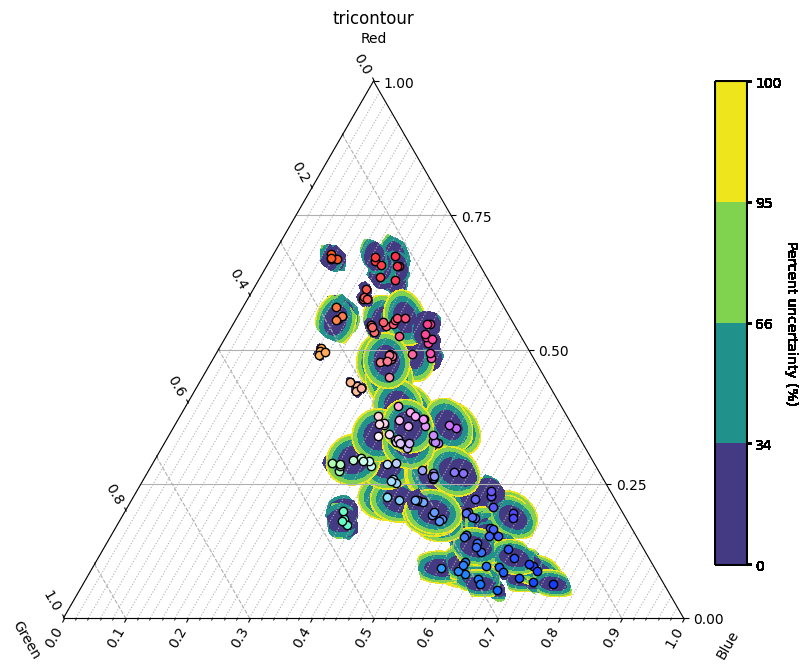

In [69]:
# 1. SET UP THE PLOT (do this only once)
fig = plt.figure(figsize=(8, 8))
bax = fig.add_subplot(projection='ternary', ternary_sum=1.0)

# Set titles and labels once
bax.set_title("Uncertainty Visualized as an Error Ellipse")
bax.set_tlabel("Red")
bax.set_llabel("Green")
bax.set_rlabel("Blue")

# Set grid and ticks once
bax.taxis.set_major_locator(MultipleLocator(0.25))
bax.laxis.set_major_locator(MultipleLocator(0.20))
bax.raxis.set_major_locator(MultipleLocator(0.10))
bax.laxis.set_minor_locator(MultipleLocator(0.1))
bax.raxis.set_minor_locator(AutoMinorLocator(5))
bax.grid(axis='t')
bax.grid(axis='l', which='minor', linestyle='--')
bax.grid(axis='r', which='both', linestyle=':')

# 2. PLOT THE DATA (loop only over the plotting calls)
for i in range(len(means)):
    #  --- Framework ---
    cs = bax.tricontourf(r_samples[i], g_samples[i], b_samples[i], entropy[i], levels=[0, 34, 66, 95, 100]  )
    bax.set_title("tricontour")

    cax = bax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=bax.transAxes)
    colorbar = fig.colorbar(cs, cax=cax)
    colorbar.set_label('Percent uncertainty (%)', rotation=270, va='baseline')



    original_color = np.array(means[i])
    # Scale the color so its brightest component is 1.0
    max_val = np.max(original_color)
    bright_color = original_color / max_val if max_val > 0 else original_color
    # The fix: provide 'c' as an RGB color and REMOVE `norm`
    
    bax.scatter(
        means[i][0], means[i][1], means[i][2],
        c=bright_color,  # Pass the [r, g, b] list as the color
        edgecolors="k",
        zorder=10,
        label=f'Tag {i}'
    )

# 3. SHOW THE LEGEND AND PLOT (do this once, after the loop)
plt.show()


In [52]:
samples=[]
for i in range(len(r_samples)):

    sample = [r_samples[i], g_samples[i], b_samples[i]]
    samples.append(sample)

In [85]:
labels = []
[labels.extend(np.ones(4)*i) for i in range(40)]
labels = np2.array(labels)

y_test = np.array(labels[::4])
X_test = np.array(samples[::4])

y_train = np.concatenate((labels[1::4], labels[2::4], labels[3::4]))
X_train = np.concatenate((samples[1::4], samples[2::4], samples[3::4]))

In [86]:
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]

X_train_reshaped = X_train.reshape(n_samples_train, -1)
X_test_reshaped = X_test.reshape(n_samples_test, -1)

In [87]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error
def scores(modelPred, actual, name):
    """Calculate predicting scores based on specific metrics."""
    print(name)
    a = accuracy_score(actual, modelPred)
    print("Accuracy: ", a)
    print("F1: ", f1_score(actual, modelPred, average='macro'))
    print("Precision: ", precision_score(actual, modelPred, average='macro', zero_division=np.nan))
    print("Recall: ", recall_score(actual, modelPred, average='macro'))
    print("MSE: ", mean_squared_error(actual, modelPred), "\n")
    return a

In [88]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(1,8):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_reshaped, y_train)
    y_pred = knn.predict(X_test_reshaped)
    scores(y_pred, y_test, f"KNN - {i}N")

KNN - 1N
Accuracy:  0.825
F1:  0.7666666666666666
Precision:  0.8939393939393939
Recall:  0.825
MSE:  55.675 

KNN - 2N
Accuracy:  0.725
F1:  0.6375
Precision:  0.82183908045977
Recall:  0.725
MSE:  67.925 

KNN - 3N
Accuracy:  0.75
F1:  0.6708333333333333
Precision:  0.8444444444444444
Recall:  0.75
MSE:  66.1 

KNN - 4N
Accuracy:  0.7
F1:  0.6125
Precision:  0.7873563218390806
Recall:  0.7
MSE:  88.625 

KNN - 5N
Accuracy:  0.675
F1:  0.5791666666666666
Precision:  0.761904761904762
Recall:  0.675
MSE:  59.2 

KNN - 6N
Accuracy:  0.625
F1:  0.5166666666666666
Precision:  0.7179487179487178
Recall:  0.625
MSE:  112.075 

KNN - 7N
Accuracy:  0.6
F1:  0.5
Precision:  0.6987179487179487
Recall:  0.6
MSE:  98.175 

